In [1]:
import ipopt
import scipy
import numpy as np
import numpy.linalg as LA
from numpy.polynomial import Chebyshev as T
import gen_mat as gen
import matplotlib.pyplot as plt
from numba import jit, prange
#from test_bench import *
from gen_points import *
%matplotlib inline
import os

#prange = xrange

In [2]:
global num_col 
num_col = 45
num_pnts = 60
global dim  
dim = 2

global obj
global error
obj = [1]
error = [1]

class hs071(object):
    def __init__(self):
        pass
    @jit(parallel = True, nogil = True)
    def objective(self, points):
        tol = 1e-12
        if (points.ndim == 1 or points.shape[1] == 1):
            points = points.reshape(-1, dim, order='F')  
        points = np.stack(np.split(points.T.ravel(),dim),1)
        A = gen.GenMat(num_col, points, poly=gen.cheb, ToGenDiff=False)
        S = LA.svd(A, compute_uv = False)
        S[ S < tol ] = tol
        ld = 2.0*np.sum(np.log(S))
        return -ld 
    
    @jit(parallel = True, nogil = True)
    def gradient(self, points):
        tol = 1e-12
        if (points.ndim == 1 or points.shape[1] == 1):
            points = points.reshape(-1, dim, order='F') 
        
        idx = np.array(gen.indeces_K_cut(dim, num_col))
        max_degree = np.max(idx)

        num_of_points = points.shape[0]
        tot_elems = points.size

        # computing values of all possible Chebyshev polynomials (and its derivatives) in the input points 
        T_deriv = np.empty((tot_elems, max_degree + 1), dtype = points.dtype)
        T_val   = np.empty((tot_elems, max_degree + 1), dtype = points.dtype)
        points_flat = points.ravel('F')
        for i in prange(max_degree + 1):
            T_deriv[:, i] = T.deriv(T.basis(i))(points_flat)
            T_val[:, i]   = T.basis(i)(points_flat)

        A = gen.GenMat(num_col, points, poly_vals=T_val, indeces=idx,  ToGenDiff=False)

        _, S, V = LA.svd(A, full_matrices = False)
        S[ S < tol ] = tol
        B_inv = V.T.dot(np.diag(1./(S**2))).dot(V)

        # key part of analytical calculation
        # here is implemented analytical formula (for multidimensional case)

        grad_vec = np.zeros(tot_elems, dtype = points.dtype)
        for k in prange(tot_elems):
            col = k//num_of_points
            row = k%num_of_points
            A_row = A[row]
            idx_col = idx.T[col]
            for i in xrange(B_inv.shape[0]):
                alpha = T_deriv[k, idx_col[i]]/T_val[k, idx_col[i]]
                for j in xrange(B_inv.shape[0]):
                    grad_vec[k] += B_inv[j,i] * (A_row[i]*A_row[j]*(alpha  + T_deriv[k, idx_col[j]]/T_val[k, idx_col[j]]))
        return -grad_vec
    
    def constraints(self, x):
        #
        # The callback for calculating the constraints
        #
        return np.array((x[x.size//2:]-2.1*x[0:x.size//2], x[x.size//2:]+2.1*x[0:x.size//2]))#np.array((np.prod(x), np.dot(x, x)))

    def jacobian(self, x):
        #
        # The callback for calculating the Jacobian
        #
            
        ret = np.zeros(2*num_pnts**2)
        ret_1 = np.zeros(2*num_pnts**2)
        
        for i in xrange(num_pnts, ret.size, 2*num_pnts + 1):
            ret[i-num_pnts] = -2.1
            ret_1[i-num_pnts] = 2.1
            ret[i] = 1.0
            ret_1[i] = 1.0
        return np.concatenate((ret,ret_1))#np.array([-1.0 + x[10], -x[0] + 1.0, -1.0 + x[11], -x[1] + 1.0, -1.0 + x[12], -x[2] + 1.0, -1.0 + x[13], -x[3] + 1.0, -1.0 + x[14], -x[4] + 1.0, -1.0 + x[15], -x[5] + 1.0, -1.0 + x[16], -x[6] + 1.0, -1.0 + x[17], -x[7] + 1.0, -1.0 + x[18], -x[8] + 1.0, -1.0 + x[19], -x[9] + 1.0])

In [6]:
def std_x(x, a, b):
    return ((x - x.min()) / (x.max() - x.min()) * (b-a) + a).flatten()

In [7]:
#x0 = np.concatenate((np.random.rand(10),-0.9*np.random.rand(10)),axis=0)#-1+2*np.random.rand(2*num_pnts)
np.random.seed(11)

x0 = test_points_gen(num_pnts, dim, distib='LHS')#np.random.rand(num_pnts,dim)
x0[:num_pnts/4,0] = std_x(test_points_gen(num_pnts/4, 1, distib='LHS'),-0.9*0.476,0.001)
x0[:num_pnts/4,1] = 2.1*x0[:num_pnts/4,0]+0.9

x0[num_pnts/4:num_pnts/2,0] = std_x(test_points_gen(num_pnts/4, 1, distib='LHS'),-0.9*0.476,0.001)
x0[num_pnts/4:num_pnts/2,1] = -2.1*x0[num_pnts/4:num_pnts/2,0]-0.9

x0[num_pnts/2:num_pnts*3/4,0] = std_x(test_points_gen(num_pnts/4, 1, distib='LHS'),0.001,0.9*0.476)
x0[num_pnts/2:num_pnts*3/4,1] = 2.1*x0[num_pnts/2:num_pnts*3/4,0]-0.9

x0[num_pnts*3/4:,0] = std_x(test_points_gen(num_pnts/4, 1, distib='LHS'),0.001,0.9*0.476)
x0[num_pnts*3/4:,1] = -2.1*x0[num_pnts*3/4:,0]+0.9

x0 = x0.ravel('F')#test_points_gen(num_pnts,dim,distrib='LHS').ravel('F')
#x0 = -1+2*np.random.rand(2*num_pnts)

lb = list(-np.ones(2*num_pnts))
ub = list(np.ones(2*num_pnts))

cl = [-0.9, -0.9]*num_pnts
cu = [0.9, 0.9]*num_pnts

nlp = ipopt.problem(
            n=len(x0),
            m = len(cl),
            problem_obj=hs071(),
            lb=lb,
            ub=ub,
            cl=cl,
            cu=cu
            )

In [8]:
nlp.addOption('mu_strategy', 'adaptive')
nlp.addOption('limited_memory_update_type', 'bfgs')
nlp.addOption('hessian_approximation', 'limited-memory')
#nlp.addOption('derivative_test','first-order')
#nlp.addOption('dual_inf_tol', np.float(1e4))
#nlp.addOption('max_iter', 95)
#nlp.addOption('compl_inf_tol', 1e-7)
nlp.addOption('constr_viol_tol', 1e-6)
#nlp.addOption('acceptable_iter', 2)
nlp.addOption('tol', 1e-10)
#nlp.addOption('jac_d_constant', 'yes')
#nlp.addOption('nlp_scaling_method', 'none')
#nlp.addOption('dual_inf_tol', 1)
#nlp.addOption('compl_inf_tol', 0.0002)

In [9]:
x, info = nlp.solve(x0)

In [10]:
def rhs(points):
    return 2*np.exp(-((points[:,0]**2)/2. + (points[:,1]**2)/2.))

In [11]:
# # approximation error (infinity norm) and comparison with MaxVol
# M_gd = gen.GenMat(num_col, x.reshape(x.size//2,2,order='F'), poly = gen.cheb, ToGenDiff=False) 
# c_gd = LA.solve(np.dot(M_gd.T, M_gd), np.dot(M_gd.T, rhs(x.reshape(x.size//2,2,order='F'))))

# np.random.seed(100500)
# test = -1 + (2)*np.random.rand(100000, dim)

# M = gen.GenMat(num_col, test, poly = gen.cheb, ToGenDiff=False) 

# print "GD error = ", LA.norm(rhs(test) - np.dot(M, c_gd), np.inf) / LA.norm(rhs(test), np.inf), "\n"

In [12]:
# fig, ax = plt.subplots(2, 1, sharex='col', sharey='row', figsize=(7,14), dpi=100)
# ax[0].plot(x0[:x0.size//2],x0[x0.size//2:],'ro', label='Initial points')
# ax[0].grid(True, which="both",axis='both',ls="--",lw=0.51)
# ax[0].legend()
# ax[0].set_xlim([-1, 1])
# ax[0].set_ylim([-1, 1])

# ax[1].plot(x[:x.size//2],x[x.size//2:],'bo', label='GD sampling')
# ax[1].grid(True, which="both",axis='both',ls="--",lw=0.51)
# ax[1].legend()
# ax[1].set_xlim([-1, 1])
# ax[1].set_ylim([-1, 1])

# plt.savefig("/Users/vitaly/Downloads/ipopt_diamond_subplots.png",\
#             dpi=300, bbox_inches='tight', transparent=True)

# plt.show()

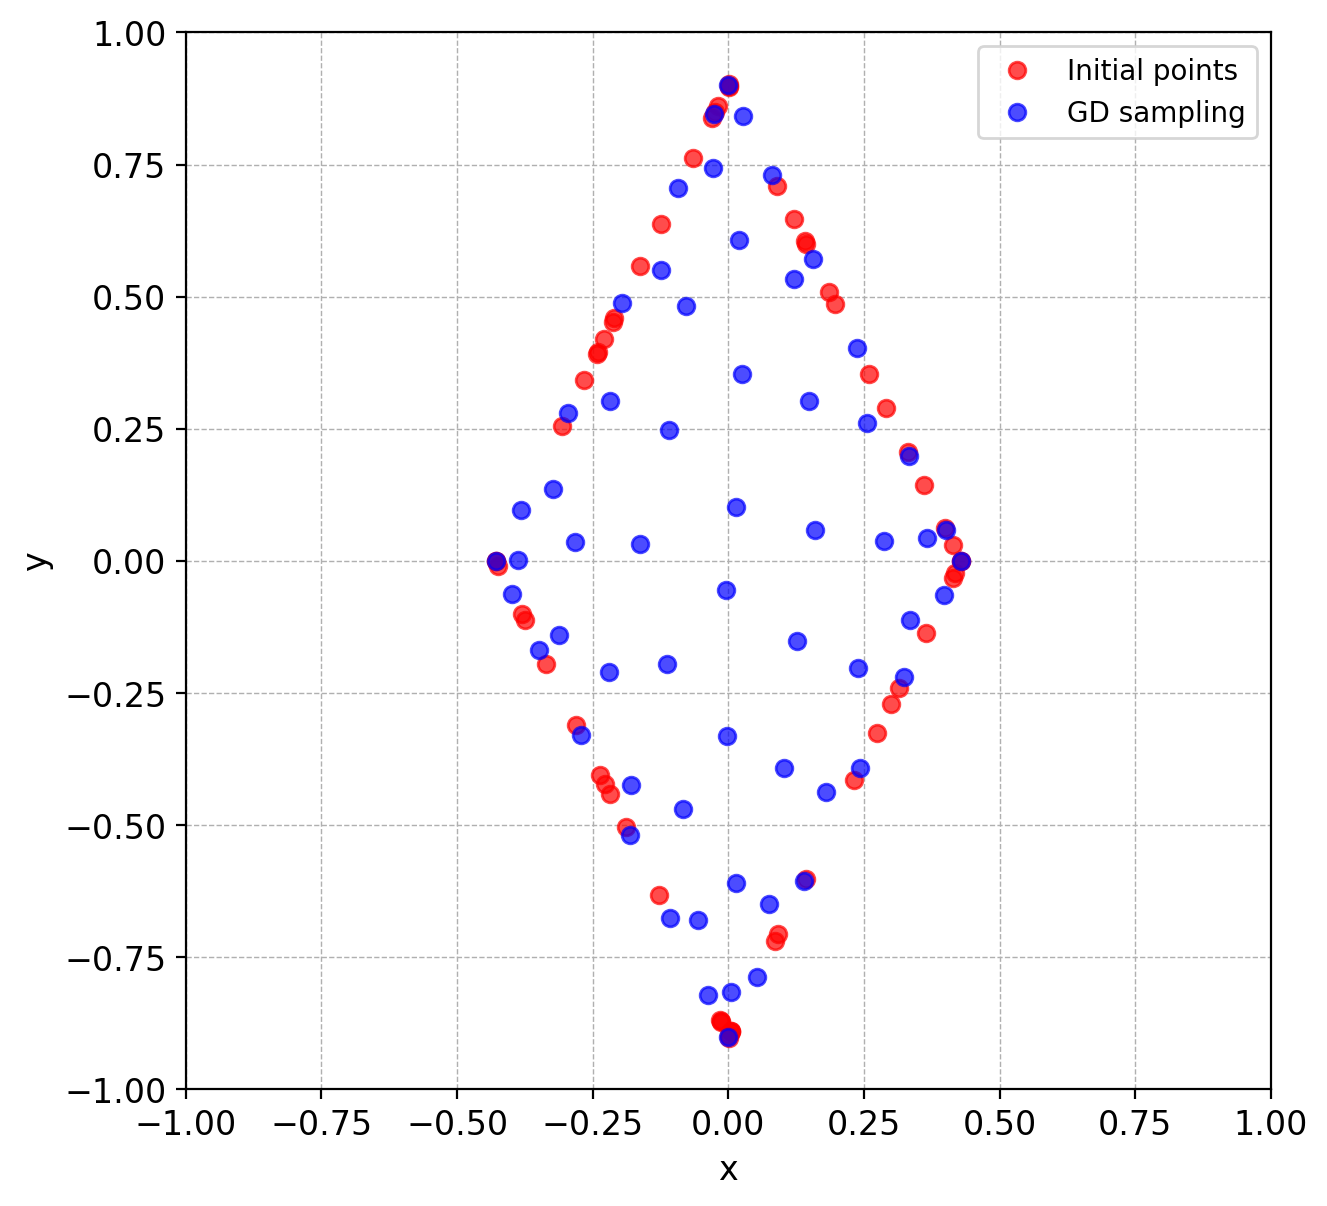

In [13]:
fig = plt.figure(figsize=(7,7), dpi=200)
plt.plot(x0[:x0.size//2],x0[x0.size//2:],'ro', label='Initial points', alpha=0.7)
plt.plot(x[:x.size//2],x[x.size//2:],'bo', label='GD sampling', alpha=0.7)

#plt.scatter(x0[:x0.size//2],x0[x0.size//2:])

#plt.plot(x0[:x0.size//2],x0[x0.size//2:],'rx', label='x0')
#plt.plot(np.arange(-1,1.2,0.1),1.5*np.arange(-1,1.2,0.1)+0.85, 'k--', np.arange(-1,1.2,0.1),1.5*np.arange(-1,1.2,0.1)-0.85, 'k--')
#plt.plot(np.arange(-1,1.2,0.1),-1.5*np.arange(-1,1.2,0.1)+0.85, 'k--', np.arange(-1,1.2,0.1),-1.5*np.arange(-1,1.2,0.1)-0.85, 'k--')
plt.xlim(-1.0,1.0)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(-1.0,1.0)
plt.xlabel('x',fontsize=12)
plt.ylabel('y',fontsize=12)
plt.grid(True, which="both",axis='both',ls="--",lw=0.51)
#plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.13),ncol=3)
plt.legend()
# plt.savefig("/Users/vitaly/Downloads/maxvol-approximation/thesis_results/results/ipopt_diamond.png",\
#             dpi=300, bbox_inches='tight', transparent=True)
# plt.savefig("/Users/vitaly/Downloads/ipopt_diamond.png",\
#             dpi=300, bbox_inches='tight', transparent=True)
plt.show()

In [ ]:
np.random.seed(42)
test_pnts = test_points_gen(int(1e5), dim)
LebesgueConst(x.reshape(-1,dim,order='F'), num_col, poly=gen.cheb, test_pnts=test_pnts, pow_p=1)